# insert titel of code

generic intro text

## imports

### Libraries

In [12]:
import pickle
import torch
import matplotlib.pyplot as plt
import argparse

### Custom scripts

In [13]:
# from scripts.args import *
from scripts.base_model.preprocessing import *
from scripts.base_model.train_base import *
from scripts.base_model.models import *
from scripts.evaluation.eval_model import *
from scripts.evaluation.get_results import *
from scripts.CEF_model.CEF_model import *
from scripts.CEF_model.train_CEF import *


## Args

### args preprocessing

sentires_dir    =       location of the preprocessed data. \
review_dir      =       location of the json dataset \
user_thresh     =       how many reviews a user needs to have \
item_thresh     =       how many reviews an item has to have \
sample_ratio    =       \
test_length     =       how many items in the test set. \
neg_length      =       amount of negative items. \
save_path       =       where the dataset object will be saved. \
user_pre        =       wether or not to use a pre created dataset. If this value is true it will use                     the data stroted in save_path.

In [20]:
def arg_parser_preprocessing():
    parser = argparse.ArgumentParser()
    parser.add_argument("--sentires_dir", dest="sentires_dir", type=str, default="data/input_data/reviews_with_features.txt", 
                        help="path to sentires data")
    parser.add_argument("--review_dir", dest="review_dir", type=str, default="data/input_data/reviews_Electronics_5_filtered.json", 
                        help="path to original review data")
    parser.add_argument("--user_thresh", dest="user_thresh", type=int, default=20, 
                        help="remove users with reviews less than this threshold")
    parser.add_argument("--item_thresh", dest="item_thresh", type=int, default=15, 
                        help="remove users with reviews less than this threshold")
    parser.add_argument("--sample_ratio", dest="sample_ratio", type=int, default=2, 
                        help="the (negative: positive sample) ratio for training BPR loss")
    parser.add_argument("--test_length", dest="test_length", type=int, default=5, 
                        help="the number of test items")
    parser.add_argument("--neg_length", dest="neg_length", type=int, default=100, help="# of negative samples in evaluation")
    parser.add_argument("--save_path", dest="save_path", type=str, default="data/preprocessed_data/Dataset_small.pickle", 
                        help="The path to save the preprocessed dataset object")
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=False, 
            help="Wether or not to use a stored dataset object")
    parser.add_argument("--extra_filter", dest="extra_filter", type=bool, default=True)
    return parser.parse_known_args()

### args Train base model

device = either cpu or cuda depending on wether you use a gpu \
batch_size = the batch size \
lr = learning rate \
rec_k = length of the recommendation list \
weight_decay = 

In [22]:
def arg_parser_training():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--gpu", default=False)
    parser.add_argument("--batch_size", dest="batch_size", type=int, default=128)
    parser.add_argument("--lr", dest="lr", type=float, default=0.01)
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--weight_decay", default=0., type=float) # not sure whether to use
    parser.add_argument("--model_path", dest="model_path", type=str, default="data/models/model_small.model", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=50)
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=True, 
            help="Wether or not to use a stored model object")
    return parser.parse_known_args()

### arg CEF

In [16]:
# todo
def arg_parser_CEF():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--ld", default=1, type=float) # not sure whether to use
    parser.add_argument("--lr", dest="lr", type=float, default=0.01)
    parser.add_argument("--model_path", dest="model_path", type=str, default="data/models/CEF_model.model", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=30)
    parser.add_argument("--use_pre", dest="use_pre", type=str, default=False, 
            help="Wether or not to use a stored model object")
    return parser.parse_known_args()

### args get results

In [17]:
def arg_parser_results():
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", dest = "device", type=str, default='cpu')
    parser.add_argument("--remove_size", dest="remove_size", type=int, default=50)
    parser.add_argument("--rec_k", dest="rec_k", type=int, default=5, help="length of rec list")
    parser.add_argument("--output_path", dest="output_path", type=str, default="results/result dicts/", 
                        help="The path to save the model")
    parser.add_argument("--epochs", dest="epochs", type=int, default=1)
    parser.add_argument("--beta", dest="beta", type=int, default=0.1 )
    return parser.parse_known_args()

## Basemodel

In [18]:
device = "cpu"

### Preprocessing

In [21]:
# get the arguments for preprocessing
preprocessing_args, unkown = arg_parser_preprocessing()
# load dataset if the dataset exist
dataset_path = preprocessing_args.save_path
if preprocessing_args.use_pre:
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset = preprocessing(preprocessing_args)
    with open(dataset_path, "wb") as f:
            pickle.dump(dataset, f)

======================= sample training data =======================
# training samples : 301086
======================= sample test data =======================
# test samples : 5105


### Train base model

In [23]:
train_args, _ = arg_parser_training()
model_path = train_args.model_path
if train_args.use_pre:
    base_model = BaseRecModel(dataset.feature_num, dataset).to(device)
    base_model.load_state_dict(torch.load(model_path))
else:
    base_model = trainmodel(train_args, dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0:  training loss:  0.54806685


  2%|▏         | 1/50 [00:15<12:53, 15.79s/it]

epoch 0:  training loss:  0.54806685 NDCG:  0.19215950424378714


  4%|▍         | 2/50 [00:23<08:41, 10.87s/it]

epoch 1:  training loss:  0.4908174


  6%|▌         | 3/50 [00:30<07:17,  9.31s/it]

epoch 2:  training loss:  0.4748058


  8%|▊         | 4/50 [00:38<06:34,  8.58s/it]

epoch 3:  training loss:  0.46587878


 10%|█         | 5/50 [00:45<06:08,  8.19s/it]

epoch 4:  training loss:  0.45957926


 12%|█▏        | 6/50 [00:53<05:49,  7.95s/it]

epoch 5:  training loss:  0.45501298


 14%|█▍        | 7/50 [01:00<05:35,  7.81s/it]

epoch 6:  training loss:  0.45095274


 16%|█▌        | 8/50 [01:08<05:24,  7.74s/it]

epoch 7:  training loss:  0.44754353


 18%|█▊        | 9/50 [01:15<05:15,  7.70s/it]

epoch 8:  training loss:  0.44421807


 20%|██        | 10/50 [01:23<05:08,  7.70s/it]

epoch 9:  training loss:  0.44144392
epoch 10:  training loss:  0.43880185


 22%|██▏       | 11/50 [01:39<06:36, 10.18s/it]

epoch 10:  training loss:  0.43880185 NDCG:  0.16732358840481165


 24%|██▍       | 12/50 [01:48<06:15,  9.89s/it]

epoch 11:  training loss:  0.43631622


 26%|██▌       | 13/50 [01:56<05:48,  9.42s/it]

epoch 12:  training loss:  0.43380016


 28%|██▊       | 14/50 [02:04<05:21,  8.93s/it]

epoch 13:  training loss:  0.43106678


 30%|███       | 15/50 [02:12<04:58,  8.52s/it]

epoch 14:  training loss:  0.4288482


 32%|███▏      | 16/50 [02:19<04:40,  8.26s/it]

epoch 15:  training loss:  0.42641696


 34%|███▍      | 17/50 [02:27<04:29,  8.15s/it]

epoch 16:  training loss:  0.4238772


 36%|███▌      | 18/50 [02:35<04:17,  8.06s/it]

epoch 17:  training loss:  0.4214629


 38%|███▊      | 19/50 [02:43<04:08,  8.00s/it]

epoch 18:  training loss:  0.41923514


 40%|████      | 20/50 [02:51<03:57,  7.91s/it]

epoch 19:  training loss:  0.4170499
epoch 20:  training loss:  0.41511744


 42%|████▏     | 21/50 [03:07<05:01, 10.41s/it]

epoch 20:  training loss:  0.41511744 NDCG:  0.16571324406298635


 44%|████▍     | 22/50 [03:15<04:32,  9.74s/it]

epoch 21:  training loss:  0.41249692


 46%|████▌     | 23/50 [03:23<04:09,  9.23s/it]

epoch 22:  training loss:  0.410216


 48%|████▊     | 24/50 [03:32<03:55,  9.06s/it]

epoch 23:  training loss:  0.4082927


 50%|█████     | 25/50 [03:40<03:37,  8.71s/it]

epoch 24:  training loss:  0.40599218


 52%|█████▏    | 26/50 [03:48<03:22,  8.43s/it]

epoch 25:  training loss:  0.40393695


 54%|█████▍    | 27/50 [03:56<03:12,  8.38s/it]

epoch 26:  training loss:  0.40120834


 56%|█████▌    | 28/50 [04:04<03:00,  8.21s/it]

epoch 27:  training loss:  0.3996501


 58%|█████▊    | 29/50 [04:11<02:50,  8.11s/it]

epoch 28:  training loss:  0.3973341


 60%|██████    | 30/50 [04:20<02:45,  8.26s/it]

epoch 29:  training loss:  0.3953428
epoch 30:  training loss:  0.39331245


 62%|██████▏   | 31/50 [04:37<03:26, 10.87s/it]

epoch 30:  training loss:  0.39331245 NDCG:  0.15339993827772255


 64%|██████▍   | 32/50 [04:45<02:59,  9.95s/it]

epoch 31:  training loss:  0.39112863


 66%|██████▌   | 33/50 [04:53<02:40,  9.46s/it]

epoch 32:  training loss:  0.38942853


 68%|██████▊   | 34/50 [05:01<02:24,  9.01s/it]

epoch 33:  training loss:  0.38715592


 70%|███████   | 35/50 [05:09<02:12,  8.80s/it]

epoch 34:  training loss:  0.38494813


 72%|███████▏  | 36/50 [05:18<02:02,  8.73s/it]

epoch 35:  training loss:  0.38300335


 74%|███████▍  | 37/50 [05:26<01:51,  8.58s/it]

epoch 36:  training loss:  0.3813499


 76%|███████▌  | 38/50 [05:34<01:40,  8.34s/it]

epoch 37:  training loss:  0.3793004


 78%|███████▊  | 39/50 [05:42<01:29,  8.16s/it]

epoch 38:  training loss:  0.37750345


 80%|████████  | 40/50 [05:49<01:19,  8.00s/it]

epoch 39:  training loss:  0.37540585
epoch 40:  training loss:  0.37341484


 82%|████████▏ | 41/50 [06:05<01:32, 10.29s/it]

epoch 40:  training loss:  0.37341484 NDCG:  0.15657787910898807


 84%|████████▍ | 42/50 [06:13<01:15,  9.49s/it]

epoch 41:  training loss:  0.37190452


 86%|████████▌ | 43/50 [06:20<01:02,  8.93s/it]

epoch 42:  training loss:  0.36948735


 88%|████████▊ | 44/50 [06:28<00:51,  8.54s/it]

epoch 43:  training loss:  0.36825413


 90%|█████████ | 45/50 [06:36<00:41,  8.28s/it]

epoch 44:  training loss:  0.3662906


 92%|█████████▏| 46/50 [06:43<00:32,  8.08s/it]

epoch 45:  training loss:  0.36477712


 94%|█████████▍| 47/50 [06:51<00:23,  7.95s/it]

epoch 46:  training loss:  0.36281475


 96%|█████████▌| 48/50 [06:58<00:15,  7.83s/it]

epoch 47:  training loss:  0.36098766


 98%|█████████▊| 49/50 [07:06<00:07,  7.78s/it]

epoch 48:  training loss:  0.3596384


100%|██████████| 50/50 [07:14<00:00,  8.68s/it]

epoch 49:  training loss:  0.3574982


### Results of base model

In [24]:
ndcg, f1, _ = eval_model(dataset, 5, base_model, device)
print(f"ndcg : {ndcg}")
print(f"f1 : {f1}")

ndcg : 0.13930157755921807
f1 : 0.13159647404505387


### CEF model

In [25]:
### stil to do.
CEF_args, _ = arg_parser_CEF()
model_path = CEF_args.model_path
CEF_model = CEF(CEF_args, dataset, base_model).to(device)
if CEF_args.use_pre:
    CEF_model.load_state_dict(torch.load(model_path))
else:
    CEF_model = train_delta(CEF_args, CEF_model)

  0%|          | 0/30 [00:00<?, ?it/s]

59315094


### Plot results

In [30]:
result_args, _ = arg_parser_results()
results = get_results(dataset, result_args, base_model, CEF_model)

  0%|          | 2/3606 [00:22<11:28:09, 11.46s/it]


KeyboardInterrupt: 

In [ ]:
def plot_results(results):
    for method in results:
        result = results[method]
        plt.scatter(result["lt"], result["ndcg"], label = method)
    
    plt.xlabel("long tail rate")
    plt.ylabel("NDCG")
    plt.legend()
    plt.show()

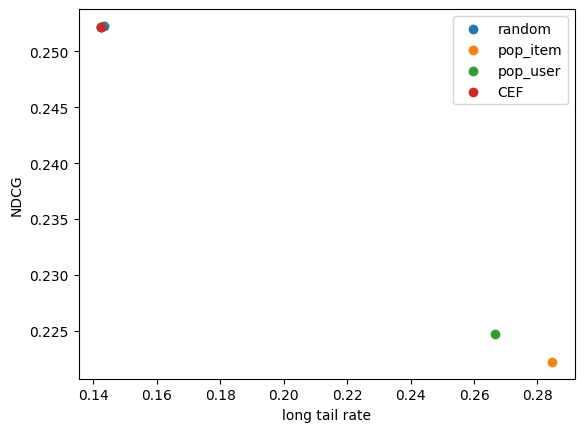

In [ ]:
plot_results(results)